In [2]:
import rebound
import reboundx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy import constants as c
from astropy import units as u
from tqdm import tqdm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib.style as mplstyle
mplstyle.use('fast')

# Basic outer solar system model using NASA Horizon

In [9]:
# Get orbital elements
import requests
import json
import numpy as np

# ['5','6','7','8','9'] = ["JUPITER BARYCENTER", "SATURN BARYCENTER", "URANUS BARYCENTER", "NEPTUNE BARYCENTER", "PLUTO BARYCENTER"]
planets = ['5','6','7','8','9']
orbital_elements = []
for planet in planets:
    # Construct the API URL
    # Date is 2004-06-01
    url = f"https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND='{planet}'&OBJ_DATA='YES'&MAKE_EPHEM='YES'&EPHEM_TYPE='ELEMENT'&CENTER='500@0'&START_TIME='2004-06-01'&STOP_TIME='2004-06-02'&STEP_SIZE='1%20d'&CSV_FORMAT='YES&OUT_UNITS='AU-D'"
    # Send an HTTP GET request to the API
    response = requests.get(url)
    
    # List: [EC, QR, IN, OM, W , Tp ,N , MA, TA ,A , AD, PR]
    #       [0   1   2   3   4   5   6   7   8   9   10  11]
    stri = response.text

    #Get just the data from string ####consider using json instead####
    data = (((stri.split('$$SOE\n')[1]).split('\n$$EOE')[0]).split('\n')[0][52:]).split(',')

    # Extract the orbital elements from the response
    a = eval(data[9]) # Semi-major axis (in AU)
    e = eval(data[0]) # Eccentricity
    inc = eval(data[2]) # Inclination (in degrees)
    Omega = eval(data[3]) # Longitude of the ascending node (in degrees)
    omega = eval(data[4]) # Argument of perihelion (in degrees)
    f = eval(data[8]) # True anomaly (in degrees)

    # Append the orbital elements to empty list
    orbital_elements.append({"a": a, "e": e, "inc": inc, "Omega": Omega, "omega": omega, "f": f})

# Convert degrees to radians
for elem in orbital_elements:
    elem["inc"] = np.deg2rad(elem["inc"])
    elem["omega"] = np.deg2rad(elem["omega"])
    elem["Omega"] = np.deg2rad(elem["Omega"])
    elem["f"] = np.deg2rad(elem["f"])

In [10]:
# Run simulation
import rebound
import numpy as np
from tqdm import tqdm

sim = rebound.Simulation()
sim.G = c.G.value
sim.units = ('yr', 'AU', 'Msun')
sim.integrator = "WHFAST"
sim.dt = 0.1

#############################################
#### Select planets ####
# For all planets use 'JSUNP', to remove a planet change letter to _
used_planets = 'JSUNP'
mask = [char!='_' for char in used_planets]
#############################################

sim.add(m=1+5.98e-6)
masses = [0.00095465,0.00028558,0.00004344,0.00005149,0]
for i in np.array([0,1,2,3,4])[mask]:
    mass = masses[i]
    elem = orbital_elements[i]
    sim.add(m=mass, a=elem["a"], e=elem["e"], inc=elem["inc"], omega=elem["omega"], Omega=elem["Omega"], f=elem["f"])
sim.move_to_com()

NN = len(sim.particles)-2


# Initialize NumPy arrays to store the orbital elements, the corresponding time intervals, and positions
n_out = 10000  # Number of timesteps to save data
ln = np.zeros(n_out)
lp = np.zeros(n_out)
pomegap = np.zeros(n_out)

xx = np.zeros(n_out)
yy = np.zeros(n_out) 

times = np.zeros(n_out)
positions = np.array([[np.zeros(n_out) for _ in range(3)] for _ in range(6)])

# Integrate the simulation, saving relevant orbital elements
particles = sim.particles
for i,t in tqdm(enumerate(np.linspace(0, 1e8,n_out)),total=n_out):
    sim.integrate(t)
    ln[i] = particles[NN].l
    lp[i] = particles[NN+1].l
    pomegap[i] = particles[NN+1].pomega
    times[i]  = t

    #
    xx[i] = np.cos(particles[NN+1].omega)*particles[NN+1].e
    yy[i] = np.sin(particles[NN+1].omega)*particles[NN+1].e

    for planet_index in range(len(particles)):
        positions[planet_index][0][i] = particles[planet_index].x
        positions[planet_index][1][i] = particles[planet_index].y
        positions[planet_index][2][i] = particles[planet_index].z

100%|██████████| 10000/10000 [11:53<00:00, 14.02it/s]


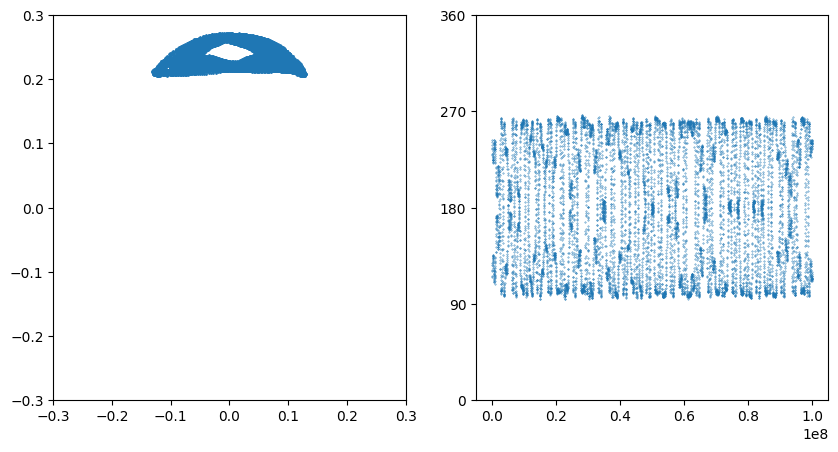

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(xx,yy,s=1)
ax[0].set_xlim(-0.3,0.3)
ax[0].set_ylim(-0.3,0.3)

phi = np.rad2deg(3*lp-2*ln-pomegap)%360
ax[1].scatter(times,phi,s=0.1)
ax[1].set_ylim(0,360)
ax[1].set_yticks([0,90,180,270,360]);

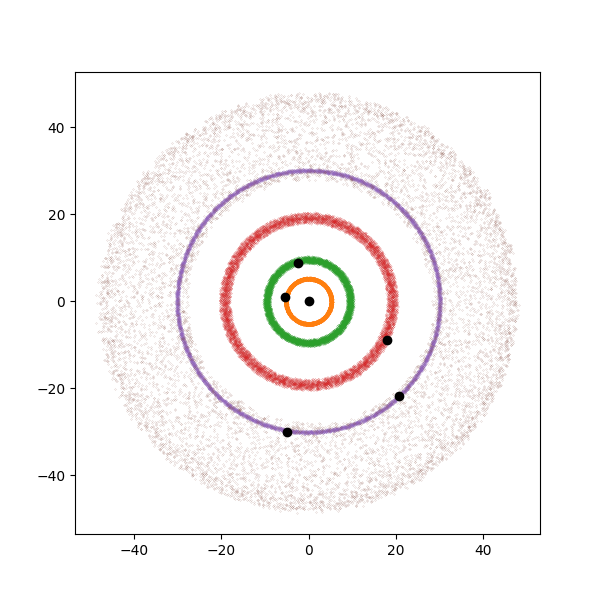

In [12]:
%matplotlib widget
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(positions[0][0],positions[0][1],s=0.01,zorder=-1)
ax.scatter(positions[1][0],positions[1][1],s=0.01,zorder=-1)
ax.scatter(positions[2][0],positions[2][1],s=0.01,zorder=-1)
ax.scatter(positions[3][0],positions[3][1],s=0.01,zorder=-1)
ax.scatter(positions[4][0],positions[4][1],s=0.01,zorder=-1)
ax.scatter(positions[5][0][0:],positions[5][1][0:],s=0.01,zorder=-1)

ax.scatter(positions[0][0][0],positions[0][1][0],color='black')
ax.scatter(positions[1][0][0],positions[1][1][0],color='black')
ax.scatter(positions[2][0][0],positions[2][1][0],color='black')
ax.scatter(positions[3][0][0],positions[3][1][0],color='black')
ax.scatter(positions[4][0][0],positions[4][1][0],color='black')
ax.scatter(positions[5][0][0],positions[5][1][0],color='black')

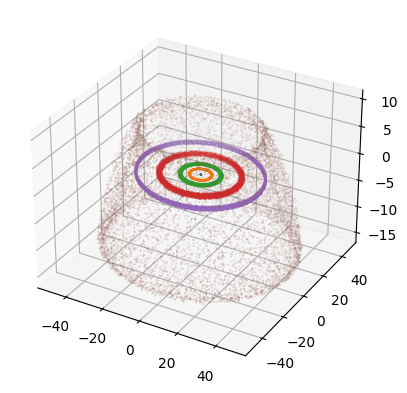

In [31]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(positions[0][0],positions[0][1],positions[0][2],s=0.01,zorder=-1)
ax.scatter(positions[1][0],positions[1][1],positions[1][2],s=0.01,zorder=-1)
ax.scatter(positions[2][0],positions[2][1],positions[2][2],s=0.01,zorder=-1)
ax.scatter(positions[3][0],positions[3][1],positions[3][2],s=0.01,zorder=-1)
ax.scatter(positions[4][0],positions[4][1],positions[4][2],s=0.01,zorder=-1)
ax.scatter(positions[5][0][0:],positions[5][1][0:],positions[5][2][0:],s=0.01,zorder=-1)

# L7 Model

In [3]:
L7     = pd.read_csv('L7MODEL/L7SyntheticModel-v09.txt',skiprows=28,sep='\s+',header=0,low_memory=False)
L7_res = pd.read_csv('L7MODEL/resonant.dat',skiprows=28,sep='\s+',header=0)
L7_sca = pd.read_csv('L7MODEL/scattering.dat',skiprows=28,sep='\s+',header=0)
L7_cla = pd.read_csv('L7MODEL/classical.dat',skiprows=28,sep='\s+',header=0)
data_52 = L7_res[L7_res['n1']/L7_res['n2']==5/2]
data_32 = L7_res[L7_res['n1']/L7_res['n2']==3/2]
data_21 = L7_res[L7_res['n1']/L7_res['n2']==2/1]

resonances = ['1/1','5/4','4/3','3/2','5/3','7/4','2/1','7/3','5/2','3/1','5/1']
res_data = [L7_res[L7_res['n1']/L7_res['n2']==eval(r)] for r in resonances]

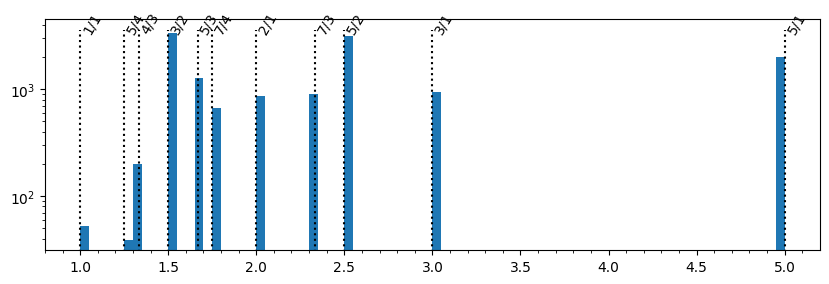

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
plt.hist(L7_res['n1']/L7_res['n2'],bins=80);
ax.xaxis.set_minor_locator(AutoMinorLocator())

for n in resonances:
    ax.text(eval(n),3400,n,fontsize=10,rotation=60)
    ax.vlines(eval(n),0,3600,color='black',linestyle='dotted')

ax.set_yscale('log')

In [6]:
mask = np.load('mask32.npy')

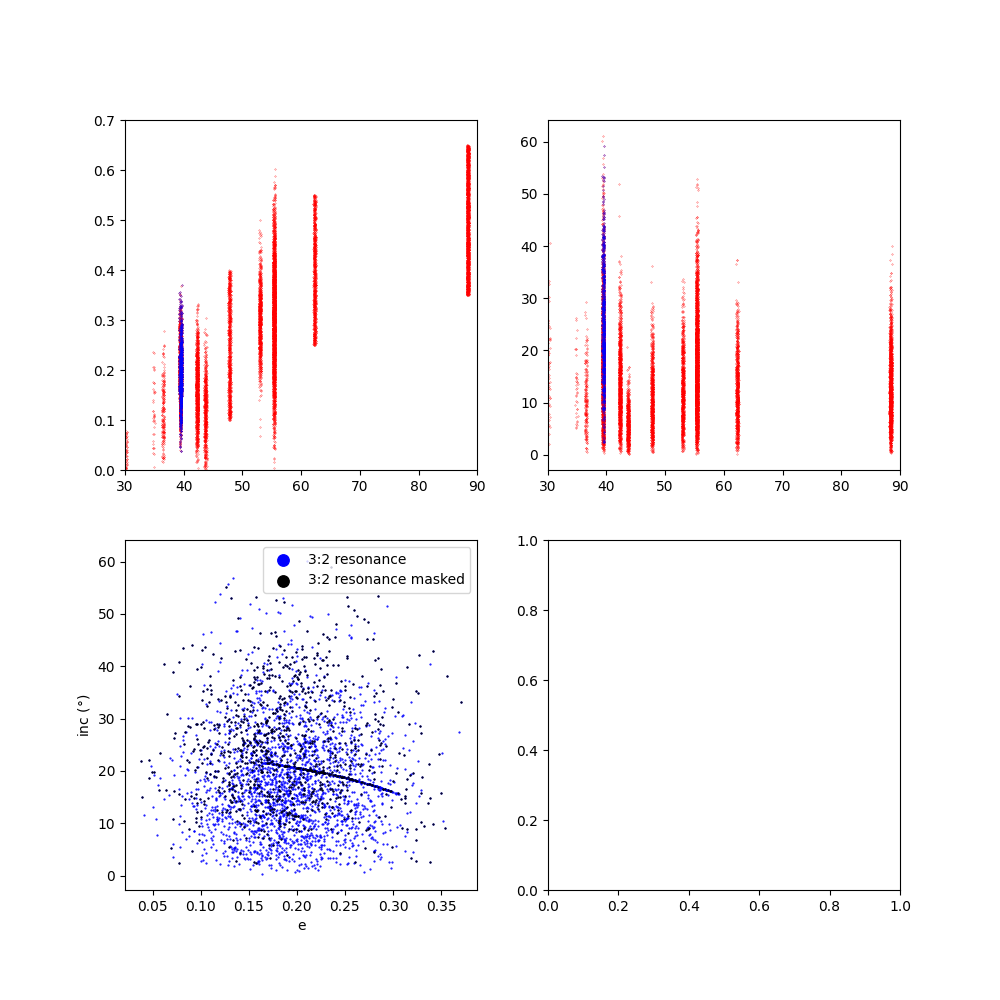

In [17]:
%matplotlib widget
fig, ax = plt.subplots(2,2,figsize=(10,10),dpi=100)
#ax[0][0].scatter(L7_cla['a'],L7_cla['e'],s=0.05,color='black')
#ax[0][0].scatter(L7_sca['a'],L7_sca['e'],s=0.05,color='blue')
ax[0][0].scatter(L7_res['a'],L7_res['e'],s=0.05,color='red')
ax[0][0].scatter(data_32['a'][mask],data_32['e'][mask],s=0.05,color='blue')
ax[0][0].set_xlim(30,90)
ax[0][0].set_ylim(0,.7)

#ax[0][1].scatter(L7_cla['a'],L7_cla['i'],s=0.05,color='black')
#ax[0][1].scatter(L7_sca['a'],L7_sca['i'],s=0.05,color='blue')
ax[0][1].scatter(L7_res['a'],L7_res['i'],s=0.05,color='red')
ax[0][1].scatter(data_32['a'][mask],data_32['i'][mask],s=0.05,color='blue')
ax[0][1].set_xlim(30,90)

#ax[1][0].scatter(L7_sca['e'],L7_sca['i'],s=0.05,color='blue')
#ax[1][0].scatter(L7_res['e'],L7_res['i'],s=0.05,color='red',label='All resonances')
#ax[1][0].scatter(data_52['e'],data_52['i'],s=0.05,color='green')
ax[1][0].scatter(data_32['e'],data_32['i'],s=0.3,color='blue',label='3:2 resonance')
ax[1][0].scatter(data_32['e'][mask],data_32['i'][mask],s=0.3,color='black',label='3:2 resonance masked')
#ax[1][0].scatter(data_21['e'],data_21['i'],s=0.05,color='pink')
#ax[1][1].scatter((L7_res['a']/30.07)**(3/2),L7_res['n1']/L7_res['n2'],s=0.1)
#ax[1][0].set_xlim(0.1,0.35)
#ax[1][0].set_ylim(14,22.5)
ax[1][0].set_xlabel('e')
ax[1][0].set_ylabel(r'inc $(\degree)$')
ax[1][0].legend(markerscale=15)

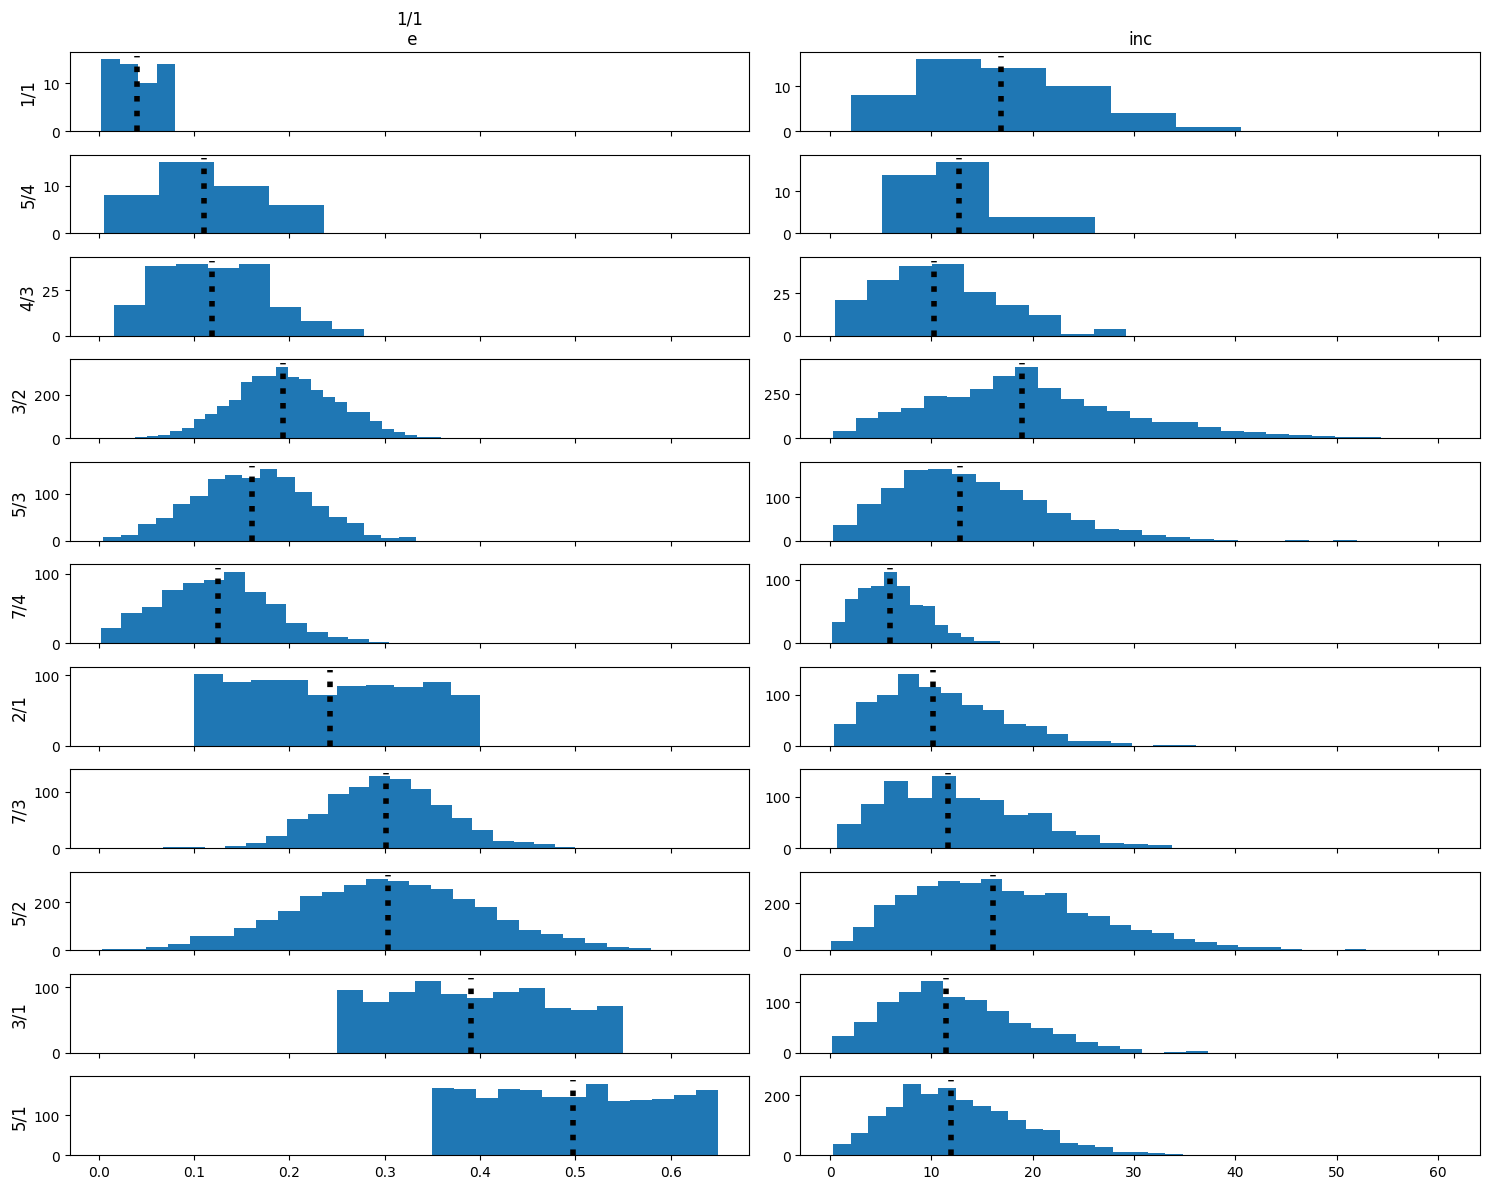

In [311]:
fig, ax = plt.subplots(len(resonances),2,figsize=(15,12),sharex='col')
for i in range(len(resonances)):
    ax[i][0].hist(res_data[i]['e'],bins='scott')
    ax[i][1].hist(res_data[i]['i'],bins='scott')
    ax[i][0].set_ylabel(resonances[i],fontsize=12)

    lim = ax[i][0].get_ylim()
    mean = np.median(res_data[i]['e'])
    ax[i][0].vlines(mean,*lim,color='black',linestyles='dotted',linewidth=4)

    lim = ax[i][1].get_ylim()
    mean = np.median(res_data[i]['i'])
    ax[i][1].vlines(mean,*lim,color='black',linestyles='dotted',linewidth=4)

ax[0][0].set_title(resonances[0]+'\n e',fontsize=12)
ax[0][1].set_title('inc',fontsize=12)
fig.tight_layout()

# Observations 

In [40]:
df = pd.read_csv("http://www.cfeps.net/L7Release/CharacterizedList.txt", delimiter=" ", skiprows=47, names=["CFEPS_ID", "type", "K", "L", "a", "e", "i", "r", "m"], skipinitialspace=True)
print(df['K'],df['L'])

0      0
1      5
2      3
3      m
4      m
      ..
164    m
165    m
166    m
167    4
168    m
Name: K, Length: 169, dtype: object 0      0
1      2
2      2
3      0
4      0
      ..
164    0
165    0
166    0
167    3
168    0
Name: L, Length: 169, dtype: int64


In [51]:
import rebound
import numpy as np
from tqdm import tqdm

sim = rebound.Simulation()
sim.G = c.G.value
sim.units = ('yr', 'AU', 'Msun')
sim.integrator = "WHFAST"
sim.dt = 1

#############################################
#### Select planets ####
# For all planets use 'JSUNP', to remove a planet change letter to _
used_planets = 'JSUNP'
mask = [char!='_' for char in used_planets]
#############################################

sim.add(m=1+5.98e-6)
masses = [0.00095465,0.00028558,0.00004344,0.00005149,0]
for i in np.array([0,1,2,3,4])[mask]:
    mass = masses[i]
    elem = orbital_elements[i]
    sim.add(m=mass, a=elem["a"], e=elem["e"], inc=elem["inc"], omega=elem["omega"], Omega=elem["Omega"], f=elem["f"])
sim.move_to_com()

NN = len(sim.particles)-2 # Neptune index


# Get L7 Model and add particles
temp = df.T
for i in range(169):
    obs_particle = temp[i]
    sim.add(m=0, a=obs_particle['a'],e=obs_particle['e'],inc=np.deg2rad(obs_particle['i']))
particles = sim.particles


# Initialize NumPy arrays to store the orbital elements, the corresponding time intervals, and positions
n_out = 10000  # Number of timesteps 
ln = np.zeros(n_out)
phi_list = np.zeros((len(particles[NN+1:]),n_out)) # Array with shape [particle_index][timestep]

# Integrate the simulation, saving relevant orbital elements

for i,t in tqdm(enumerate(np.linspace(0, 1e7,n_out)),total=n_out):
    sim.integrate(t)
    for j,particle in enumerate(particles[NN+1:]):
        ln              = particles[NN].l
        l_particle      = particle.l
        pomega_particle = particle.pomega
        phi_list[j][i]     = np.rad2deg(3*l_particle-2*ln-pomega_particle)%360


100%|██████████| 10000/10000 [12:44<00:00, 13.08it/s]


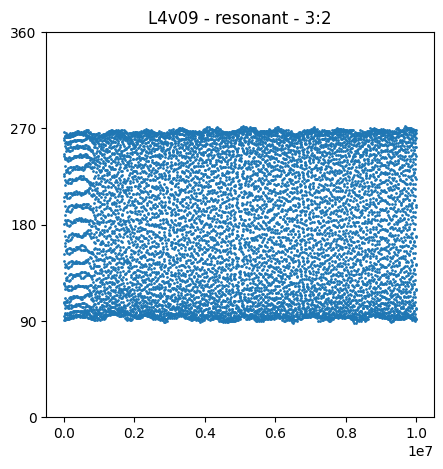

In [59]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
index = 124
ax.scatter(np.linspace(0, 1e7,n_out),phi_list[index],s=1)
if index == 0:
    ax.set_title('Pluto')
else:
    title = df['CFEPS_ID'][index-1]+' - '+df['type'][index-1]+' - '+str(df['K'][index-1])+':'+str(df['L'][index-1])
    ax.set_title(f'{title}')
ax.set_ylim(0,360)
ax.set_yticks([0,90,180,270,360]);